In [ ]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid, NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx

random.seed(133)
np.random.seed(133)

def weighted_average(history, decay=0.8):
    weights = [decay**i for i in range(len(history)-1, -1, -1)]
    weights = np.array(weights) / sum(weights)
    return np.sum(np.array(history) * weights)

def compute_avalanches(series, delta=0.01):
    return np.diff(series)[np.diff(series) > delta]

class Household(Agent):
    def __init__(self, unique_id, model, P, C0, alpha, bin_id):
        super().__init__(unique_id, model)
        self.P, self.C0, self.alpha, self.bin_id = P, C0, alpha, bin_id
        self.lambda_param = model.lambda_param
        self.local_random = np.random.RandomState(model.seed + unique_id)
        self.logit = model.logit
        self.memory_length = model.memory_length
        self.rho_history = deque(maxlen=self.memory_length)
        self.deltaC_history = deque(maxlen=self.memory_length)
        self.decay = model.decay
        self.s = self.random.random() < 0.5
        self.hat_rho = 0.0
        self.hat_deltaC = 0.0
        self.rho = 0.0
        self.deltaC = 0.0

    def step(self):
        if self.rho_history:
            self.hat_rho = weighted_average(self.rho_history, decay=self.decay)
        if self.deltaC_history:
            self.hat_deltaC = weighted_average(self.deltaC_history, decay=self.decay)
        U_R = self.P - (self.C0 + self.hat_deltaC) + self.alpha * self.hat_rho
        U_N = - self.alpha * self.hat_rho
        if self.logit:
            m = max(U_R, U_N)
            exp_R = math.exp((U_R - m) * self.lambda_param)
            exp_N = math.exp((U_N - m) * self.lambda_param)
            p_R = exp_R / (exp_R + exp_N)
            self.s = (self.local_random.random() < p_R)
        else:
            self.s = U_R > U_N

    def advance(self):
        neigh_ids = self.model.net.get_neighbors(self.unique_id)
        self.rho = np.mean([self.model.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
        if self.s:
            self.model.bins[self.bin_id].Q_m += 1
        self.rho_history.append(self.rho)
        self.deltaC_history.append(self.deltaC)

class Bin(Agent):
    def __init__(self, unique_id, model, K_m, pos):
        super().__init__(unique_id, model)
        self.K_m, self.Q_m, self.pos = K_m, 0, pos

    def step(self): pass
    def advance(self): pass

class RecyclingModel(Model):
    def __init__(self, N=100, L=10, M=9, beta=0.15, delta=1.0, c=0.3, kappa=0.1,
                 epsilon=0.05, alpha=0.6, K_default=3, memory_length=10,
                 logit=True, lambda_param=10.0, seed=133, activation='random', decay=0.9):
        super().__init__()

        self.seed = seed
        self.random = np.random.RandomState(self.seed)
        self.num_agents, self.num_bins = N, M
        self.delta, self.c, self.kappa, self.epsilon = delta, c, kappa, epsilon
        self.alpha, self.K_default = alpha, K_default
        self.memory_length = memory_length
        self.logit = logit
        self.lambda_param = lambda_param
        self.decay = decay

        L = max(L, int(np.ceil(np.sqrt(N))))
        self.grid_size = L
        self.grid = MultiGrid(width=L, height=L, torus=False)

        # Network to enable cascading influence (denser p)
        self.G = nx.erdos_renyi_graph(n=N, p=beta, seed=self.random.randint(1e9))
        self.net = NetworkGrid(self.G)
        self.schedule = SimultaneousActivation(self)

        # Create bins
        self.households, self.bins = {}, {}
        bin_positions = [(x, y) for x in np.linspace(2, L - 3, 3, dtype=int)
                               for y in np.linspace(2, L - 3, 3, dtype=int)]
        for m, (x_m, y_m) in enumerate(bin_positions[:M]):
            bin_id = N + m
            bin_agent = Bin(bin_id, self, K_default, (x_m, y_m))
            self.bins[m] = bin_agent
            self.grid.place_agent(bin_agent, (x_m, y_m))
            self.schedule.add(bin_agent)

        coords = [(i, j) for i in range(L) for j in range(L)]
        coords = coords[:N]

        P_vals = np.random.rand(N)
        champions = self.random.choice(N, size=int(epsilon * N), replace=False)
        for i in champions:
            P_vals[i] = 2.0

        for i in range(N):
            x_i, y_i = coords[i]
            dists = [np.linalg.norm(np.array((x_i, y_i)) - np.array(self.bins[m].pos)) for m in self.bins]
            bin_id = int(np.argmin(dists))
            C0_i = 0.0 if i in champions else c + kappa * dists[bin_id]
            agent = Household(i, self, P_vals[i], C0_i, 1.0 if i in champions else alpha, bin_id)
            self.households[i] = agent
            self.schedule.add(agent)
            self.grid.place_agent(agent, coords[i])
            self.net.place_agent(agent, i)

        for i, agent in self.households.items():
            neigh_ids = self.net.get_neighbors(i)
            agent.rho = np.mean([self.households[j].s for j in neigh_ids]) if neigh_ids else 0.0
            agent.deltaC = 0.0
            agent.hat_rho = agent.rho
            agent.hat_deltaC = 0.0

        self.datacollector = DataCollector(
            model_reporters={
                "Global_Recycle_Rate": lambda m: np.mean([h.s for h in m.households.values()]),
                "Average_Rho": lambda m: np.mean([h.rho for h in m.households.values()]),
                "Overloaded_Bins": lambda m: sum(1 for b in m.bins.values() if b.Q_m > b.K_m),
                "Bin_Overloads": lambda m: [max(0, b.Q_m - b.K_m) for b in m.bins.values() if b.Q_m > b.K_m]
            },
            agent_reporters={"Strategy": lambda a: a.s if isinstance(a, Household) else None}
        )

    def step(self):
        for b in self.bins.values():
            b.Q_m = 0
        self.schedule.step()
        for agent in self.households.values():
            bin_agent = self.bins[agent.bin_id]
            agent.deltaC = self.delta * max(0, bin_agent.Q_m - bin_agent.K_m)
        self.datacollector.collect(self)

(2.203141600193675,
 1.0,
 0.2774941988560568,
 -27.10663875645085,
 0.0002150304024963286,
 -21.53351616635797,
 0.19369211552507126)

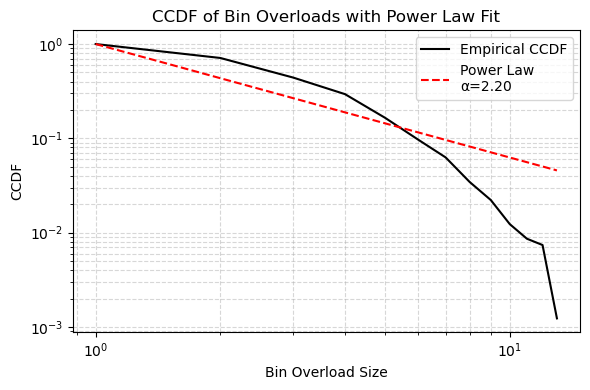

In [6]:
from collections import Counter
import numpy as np
import powerlaw
import matplotlib.pyplot as plt

# Initialize and run the model
model = RecyclingModel(N=200, L=15, M=9, beta=0.05, delta=0.5, c=0.3, kappa=0.05,
                       epsilon=0.05, alpha=0.4, K_default=10, memory_length=10,
                       logit=True, lambda_param=2.0, seed=42, activation='simultaneous', decay=0.8)

overload_sizes = []

# Simulate the model for several steps and record overloads
for _ in range(200):
    model.step()
    for bin_agent in model.bins.values():
        overload = max(0, bin_agent.Q_m - bin_agent.K_m)
        if overload > 0:
            overload_sizes.append(overload)

# Convert to numpy array and filter
overload_sizes = np.array(overload_sizes)
valid_overloads = overload_sizes[overload_sizes > 0.5]

# Fit power-law model
fit = powerlaw.Fit(valid_overloads, xmin=1.0, discrete=False)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
ks_distance = fit.power_law.D

# Compare with other distributions
R_lognormal, p_lognormal = fit.distribution_compare('power_law', 'lognormal')
R_exponential, p_exponential = fit.distribution_compare('power_law', 'exponential')

# Plot the CCDF with power-law fit
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
fit.plot_ccdf(color='black', label="Empirical CCDF")
fit.power_law.plot_ccdf(ax=ax, color='red', linestyle='--', label=f"Power Law\nα={alpha:.2f}")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Bin Overload Size")
plt.ylabel("CCDF")
plt.title("CCDF of Bin Overloads with Power Law Fit")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()

# Output summary
alpha, xmin, ks_distance, R_lognormal, p_lognormal, R_exponential, p_exponential


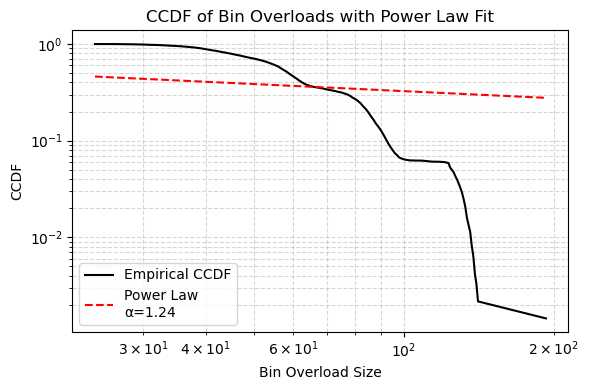

(1.2437360487578597,
 1.0,
 0.5524949684976223,
 -11234.669056025272,
 0.0,
 -7552.4729099632095,
 0.0)

In [2]:
from joblib import Parallel, delayed
import numpy as np
import powerlaw
import matplotlib.pyplot as plt
from collections import Counter

# Assuming RecyclingModel is already defined and imported.

# --- Function to run one simulation and collect overloads ---
def run_model_and_collect_overflows(seed):
    model = RecyclingModel(
        N=1000, L=10, M=9,
        beta=0.5, delta=1.0, c=0.3, kappa=0.05,
        epsilon=0.05, alpha=1.5, K_default=3,
        memory_length=10, logit=True, lambda_param=10.0,
        seed=seed
    )
    overloads = []
    for _ in range(1000):
        model.step()
        for b in model.bins.values():
            overflow = max(0, b.Q_m - b.K_m)
            if overflow > 0:
                overloads.append(overflow)
    return overloads

# --- Run in parallel ---
n_jobs = -1
n_runs = 4
all_overloads = Parallel(n_jobs=n_jobs)(
    delayed(run_model_and_collect_overflows)(seed) for seed in range(n_runs)
)

# --- Flatten results ---
all_overloads_flat = [item for sublist in all_overloads for item in sublist]
overloads = np.array(all_overloads_flat)
valid_overloads = overloads[overloads > 0.5]

# --- Power-law fitting ---
fit = powerlaw.Fit(valid_overloads, xmin=1.0, discrete=False)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
ks_distance = fit.power_law.D
R_lognormal, p_lognormal = fit.distribution_compare('power_law', 'lognormal')
R_exponential, p_exponential = fit.distribution_compare('power_law', 'exponential')

# --- Plot ---
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
fit.plot_ccdf(color='black', label="Empirical CCDF")
fit.power_law.plot_ccdf(ax=ax, color='red', linestyle='--', label=f"Power Law\nα={alpha:.2f}")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Bin Overload Size")
plt.ylabel("CCDF")
plt.title("CCDF of Bin Overloads with Power Law Fit")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- Results ---
alpha, xmin, ks_distance, R_lognormal, p_lognormal, R_exponential, p_exponential
